In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.cm import rainbow
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
data = pd.read_csv(io.BytesIO(uploaded['Train_Test_IoT_Modbus.csv']))

Saving Train_Test_IoT_Modbus.csv to Train_Test_IoT_Modbus.csv


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51106 entries, 0 to 51105
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ts                         51106 non-null  int64 
 1   date                       51106 non-null  object
 2   time                       51106 non-null  object
 3   FC1_Read_Input_Register    51106 non-null  int64 
 4   FC2_Read_Discrete_Value    51106 non-null  int64 
 5   FC3_Read_Holding_Register  51106 non-null  int64 
 6   FC4_Read_Coil              51106 non-null  int64 
 7   label                      51106 non-null  int64 
 8   type                       51106 non-null  object
dtypes: int64(6), object(3)
memory usage: 3.5+ MB


In [ ]:
data.isnull().sum()

ts                           0
date                         0
time                         0
FC1_Read_Input_Register      0
FC2_Read_Discrete_Value      0
FC3_Read_Holding_Register    0
FC4_Read_Coil                0
label                        0
type                         0
dtype: int64

In [ ]:
data.drop(["ts","date","time","label"],axis=1,inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51106 entries, 0 to 51105
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   FC1_Read_Input_Register    51106 non-null  int64 
 1   FC2_Read_Discrete_Value    51106 non-null  int64 
 2   FC3_Read_Holding_Register  51106 non-null  int64 
 3   FC4_Read_Coil              51106 non-null  int64 
 4   type                       51106 non-null  object
dtypes: int64(4), object(1)
memory usage: 1.9+ MB


In [ ]:
data['type'].value_counts()

normal       35000
backdoor      5000
injection     5000
password      5000
xss            577
scanning       529
Name: type, dtype: int64

In [ ]:
data.describe()

,FC1_Read_Input_Register,FC2_Read_Discrete_Value,FC3_Read_Holding_Register,FC4_Read_Coil
count,51106.000000,51106.000000,51106.000000,51106.000000
mean,32757.773627,32777.699879,32503.208743,32828.110594
std,18882.845454,19013.367817,18917.049504,18864.069304
min,0.000000,0.000000,0.000000,0.000000
25%,16500.000000,16436.000000,16290.000000,16495.000000
50%,32450.000000,32708.000000,32035.000000,32728.000000
75%,49033.000000,49235.000000,48826.000000,48979.250000
max,65527.000000,65535.000000,65525.000000,65534.000000


In [ ]:
#data.hist(bins=50, figsize=(20,15))

In [ ]:
data['type']=data['type'].apply(lambda x: 1 if x=="backdoor" else ( 2 if x=="password" else(3 if x=="xss" else(4 if x=="injection" else(5 if x=="scanning" else 0)))))

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3, random_state = 42)
for train_index, test_index in split.split(data,data['type']):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

In [ ]:
data = strat_train_set.copy()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35774 entries, 50705 to 19085
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   FC1_Read_Input_Register    35774 non-null  int64
 1   FC2_Read_Discrete_Value    35774 non-null  int64
 2   FC3_Read_Holding_Register  35774 non-null  int64
 3   FC4_Read_Coil              35774 non-null  int64
 4   type                       35774 non-null  int64
dtypes: int64(5)
memory usage: 1.6 MB


# Training using SVM 

In [ ]:
X_train = strat_train_set.drop("type", axis=1)
Y_train = strat_train_set["type"].copy()
X_test = strat_test_set.drop("type", axis=1)
Y_test = strat_test_set["type"].copy()

In [ ]:
from sklearn.svm import SVC
classifier = SVC(kernel='rbf', random_state = 1)
classifier.fit(X_train,Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
Y_pred = classifier.predict(X_test)

In [ ]:
strat_test_set["Predictions"] = Y_pred

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test,Y_pred)
accuracy = float(cm.diagonal().sum())/len(Y_test)
print("\nAccuracy Of SVM For The Given Dataset : ", accuracy)


Accuracy Of SVM For The Given Dataset :  0.6848421601878424


In [ ]:
cm

array([[10500,     0,     0,     0,     0,     0],
       [ 1500,     0,     0,     0,     0,     0],
       [ 1500,     0,     0,     0,     0,     0],
       [  173,     0,     0,     0,     0,     0],
       [ 1500,     0,     0,     0,     0,     0],
       [  159,     0,     0,     0,     0,     0]])

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C':[0.1,1,10],'kernel':['rbf'],'gamma':[1,0.1]}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)
grid.fit(X_train,Y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.685, total= 2.0min
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.685, total= 2.0min
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.0min remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.685, total= 2.0min
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.685, total= 2.0min
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.685, total= 2.0min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.685, total= 2.0min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.685, total= 2.0min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.685, total= 2.0min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.685, total= 2.0min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 66.2min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [ ]:
grid.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [ ]:
grid.best_estimator_

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

# 10-Fold cross validation

In [ ]:
from sklearn.model_selection import StratifiedKFold 
folds = StratifiedKFold(n_splits=10)

In [ ]:
folds

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

In [ ]:
def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
scores_svm = []
for train_index, test_index in folds.split(digits.data,digits.target):
  X_train, X_test, Y_train, Y_test = digits.data[train_index],digits.data[test_index],digits.target[train_index],digits.target[test_index]
  scores_svm.append(get_score(SVC(gamma='auto'), X_train, X_test, Y_train, Y_test))

In [ ]:
scores_svm

[0.4388888888888889,
 0.5777777777777777,
 0.4666666666666667,
 0.3888888888888889,
 0.4722222222222222,
 0.4,
 0.5055555555555555,
 0.5754189944134078,
 0.5586592178770949,
 0.43575418994413406]

# Testing the model obtained after HYPER PARAMETER TUNING

In [ ]:
X_train1 = strat_train_set.drop("type", axis=1)
Y_train1 = strat_train_set["type"].copy()
X_test1 = strat_test_set.drop("type", axis=1)
Y_test1 = strat_test_set["type"].copy()

modelnew1 = SVC(C = 1, gamma = 1, kernel="rbf", random_state = 1)
modelnew1.fit(X_test1,Y_test1)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
from sklearn.metrics import classification_report
Y_pred1 = modelnew1.predict(X_test1)
print(classification_report(Y_test1,Y_pred1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10500
           1       1.00      1.00      1.00      1500
           2       1.00      1.00      1.00      1500
           3       1.00      0.99      1.00       173
           4       1.00      1.00      1.00      1500
           5       1.00      0.99      0.99       159

    accuracy                           1.00     15332
   macro avg       1.00      1.00      1.00     15332
weighted avg       1.00      1.00      1.00     15332



In [ ]:
modelnew1.score(X_test1,Y_test1)

0.9996738846856248

In [ ]:
cm1 = confusion_matrix(Y_test1,Y_pred1)

In [ ]:
cm1

array([[10500,     0,     0,     0,     0,     0],
       [    1,  1499,     0,     0,     0,     0],
       [    1,     0,  1499,     0,     0,     0],
       [    1,     0,     0,   172,     0,     0],
       [    0,     0,     0,     0,  1500,     0],
       [    2,     0,     0,     0,     0,   157]])

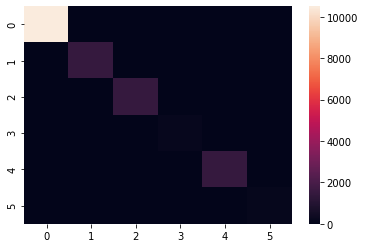

In [ ]:
import seaborn as sns
sns.heatmap(cm1)

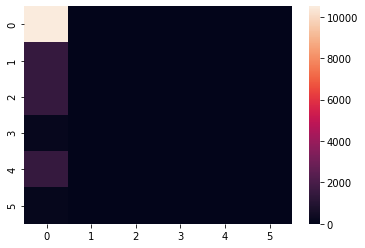

In [ ]:
import seaborn as sns
sns.heatmap(cm)